In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Define column names
column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 27)]
train_df = pd.read_csv('./dataset/train_FD001.txt', sep='\s+', header=None, names=column_names)
test_df = pd.read_csv('./dataset/test_FD001.txt', sep='\s+', header=None, names=column_names)
true_rul = pd.read_csv('./dataset/RUL_FD001.txt', header=None)

# Data Preprocessing
- Dropping unnecessary columns
- Normalization (Min Max Scaling)
- Labelling of Data

### Dropping columns

In [3]:
# Dropping Columns
columns_to_drop = ["setting1", "setting2", "setting3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor22", "sensor23", "sensor24", "sensor25", "sensor26"]
train_df_dropped = train_df.drop(columns=columns_to_drop)
test_df_dropped = test_df.drop(columns=columns_to_drop)

### Normalization

In [4]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Separate the columns to normalize and the columns to skip
columns_to_skip = train_df_dropped.columns[:2]
columns_to_normalize = train_df_dropped.columns[2:]

# Normalize only the selected columns
normalized_data = scaler.fit_transform(train_df_dropped[columns_to_normalize])

# Combine the normalized and unnormalized columns
train_df_normalized = pd.DataFrame(train_df_dropped[columns_to_skip].values, columns=columns_to_skip)
train_df_normalized = pd.concat([train_df_normalized, pd.DataFrame(normalized_data, columns=columns_to_normalize)], axis=1)

# Normalize the test data
test_normalized_data = scaler.transform(test_df_dropped[columns_to_normalize])

# Combine the normalized and unnormalized columns
test_df_normalized = pd.DataFrame(test_df_dropped[columns_to_skip].values, columns=columns_to_skip)
test_df_normalized = pd.concat([test_df_normalized, pd.DataFrame(test_normalized_data, columns=columns_to_normalize)], axis=1)

# Display the normalized DataFrame
print("Normalized Data (0-1 range):")
print(train_df_normalized.head())

Normalized Data (0-1 range):
   engine_id  cycle   sensor2   sensor3   sensor4   sensor7   sensor8  \
0          1      1  0.183735  0.406802  0.309757  0.726248  0.242424   
1          1      2  0.283133  0.453019  0.352633  0.628019  0.212121   
2          1      3  0.343373  0.369523  0.370527  0.710145  0.272727   
3          1      4  0.343373  0.256159  0.331195  0.740741  0.318182   
4          1      5  0.349398  0.257467  0.404625  0.668277  0.242424   

    sensor9  sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  \
0  0.109755  0.369048  0.633262  0.205882  0.199608  0.363986  0.333333   
1  0.100242  0.380952  0.765458  0.279412  0.162813  0.411312  0.333333   
2  0.140043  0.250000  0.795309  0.220588  0.171793  0.357445  0.166667   
3  0.124518  0.166667  0.889126  0.294118  0.174889  0.166603  0.333333   
4  0.149960  0.255952  0.746269  0.235294  0.174734  0.402078  0.416667   

   sensor20  sensor21  
0  0.713178  0.724662  
1  0.666667  0.731014  
2  0.6279

### Data Labelling

In [5]:
# Labelling of Data with RUL and Piecewise
# 1) Labelling RUL
train_df_normalized['RUL'] = train_df_normalized.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# 2) Labelling PWRUL
# Set the early RUL threshold
early_rul_threshold = 120

# Define the piecewise linear degradation function
def piecewise_rul(cycle, max_cycle):
    remaining_life = max_cycle - cycle
    if remaining_life > early_rul_threshold:
        return early_rul_threshold  # slower degradation in the early phase
    else:
        return remaining_life  # direct linear degradation after threshold
    
train_df_normalized["PWRUL"] = train_df_normalized.apply(lambda row: piecewise_rul(row['cycle'], row['cycle'] + row['RUL']), axis=1)

### Splitting Training Data For Validation

In [6]:
from sklearn.model_selection import train_test_split

# Step 1: Extract Unique Engine IDs
engine_ids = train_df_normalized['engine_id'].unique()

# Step 2: Split Engine IDs into Training and Testing Sets
train_engine_ids, test_engine_ids = train_test_split(
    engine_ids, test_size=0.2, random_state=42
)

# Step 3: Filter Data Based on Engine IDs
train_data = train_df_normalized[train_df_normalized['engine_id'].isin(train_engine_ids)].reset_index(drop=True)
validation_data = train_df_normalized[train_df_normalized['engine_id'].isin(test_engine_ids)].reset_index(drop=True)


### Prepping Data using Sliding Window for LSTM, Bi-LSTM, CNN-LSTM

In [7]:
# Prepping training data
sequence_length = 30

# Identify feature columns
feature_columns = [col for col in train_data.columns if col not in ['engine_id', 'cycle', 'RUL', 'PWRUL']]

# Initialize lists for sequences and labels
X = []
y = []

# Generate sequences and labels
# Sliding window approach
for engine_id in train_data['engine_id'].unique():
    engine_data = train_data[train_data['engine_id'] == engine_id].reset_index(drop=True)
    for i in range(sequence_length, len(engine_data)):
        # Extract sequence of sensor readings
        seq_x = engine_data[feature_columns].iloc[i-sequence_length:i].values
        # Extract the RUL value at the end of the sequence
        seq_y = engine_data['PWRUL'].iloc[i]
        X.append(seq_x)
        y.append(seq_y)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print("Input shape:", X.shape)
print("Labels shape:", y.shape)

Input shape: (14161, 30, 14)
Labels shape: (14161,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional


# Training LSTM

In [9]:
# LSTM
lstm_model = Sequential()

# CNN layers for spatial feature extraction
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(feature_columns))))
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2))  # Downsampling to reduce the sequence length
lstm_model.add(Dropout(0.2))

# LSTM layers for temporal pattern recognition
lstm_model.add(LSTM(units=128, return_sequences=True, activation='tanh'))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=64, activation='tanh', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=32, activation='tanh'))
lstm_model.add(Dropout(0.2))

# Fully connected layers
lstm_model.add(Dense(units=96, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(units=128, activation='relu'))
lstm_model.add(BatchNormalization())

# Output layer
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
print(lstm_model.summary())

# Training the Model
history = lstm_model.fit(X, y, 
                         epochs=50, 
                         batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            2752      
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 13, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 13, 128)           0         
                                                        

# Training CNN-LSTM

In [10]:
# CNN-LSTM
# Define the model (CNN-LSTM)
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(feature_columns))))
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(units=100))
cnn_lstm_model.add(Dense(units=1))

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

print(cnn_lstm_model.summary())

# Training the Model
history = cnn_lstm_model.fit(X, y, 
                    epochs=50, 
                    batch_size=64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 28, 64)            2752      
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 100)               66000     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 81,205
Trainable params: 81,205
Non-trainable params: 0
__________________________________________________

# Training Bi-LSTM

In [11]:
 # Define the model
bi_lstm_model = Sequential()

# Bidirectional LSTM layers
bi_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh'), input_shape=(sequence_length, len(feature_columns))))
bi_lstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh')))
bi_lstm_model.add(Bidirectional(LSTM(units=32, activation='tanh')))

# Fully connected layers
bi_lstm_model.add(Dense(units=96, activation='relu'))
bi_lstm_model.add(Dense(units=128, activation='relu'))

# Output layer
bi_lstm_model.add(Dense(units=1))

# Compile the model
bi_lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = bi_lstm_model.fit(X, y, 
                           epochs=15, 
                        #    validation_data=(processed_val_data, processed_val_targets),
                           batch_size=64, 
                           verbose=2)


Epoch 1/15
222/222 - 18s - loss: 2295.1606 - 18s/epoch - 83ms/step
Epoch 2/15
222/222 - 15s - loss: 1621.3164 - 15s/epoch - 66ms/step
Epoch 3/15
222/222 - 15s - loss: 1620.7627 - 15s/epoch - 66ms/step
Epoch 4/15
222/222 - 15s - loss: 1559.1099 - 15s/epoch - 66ms/step
Epoch 5/15
222/222 - 15s - loss: 604.7426 - 15s/epoch - 67ms/step
Epoch 6/15
222/222 - 15s - loss: 370.2190 - 15s/epoch - 67ms/step
Epoch 7/15
222/222 - 15s - loss: 360.6395 - 15s/epoch - 67ms/step
Epoch 8/15
222/222 - 15s - loss: 339.2401 - 15s/epoch - 67ms/step
Epoch 9/15
222/222 - 15s - loss: 322.8030 - 15s/epoch - 68ms/step
Epoch 10/15
222/222 - 15s - loss: 282.1549 - 15s/epoch - 68ms/step
Epoch 11/15
222/222 - 15s - loss: 217.3844 - 15s/epoch - 67ms/step
Epoch 12/15
222/222 - 15s - loss: 200.3499 - 15s/epoch - 67ms/step
Epoch 13/15
222/222 - 15s - loss: 189.6028 - 15s/epoch - 67ms/step
Epoch 14/15
222/222 - 15s - loss: 170.9313 - 15s/epoch - 65ms/step
Epoch 15/15
222/222 - 14s - loss: 170.6362 - 14s/epoch - 64ms/step


# Validation of Models

In [12]:
# Prepping validation data
X_test = []
y_test = []

for engine_id in validation_data['engine_id'].unique():
    engine_data = validation_data[validation_data['engine_id'] == engine_id].reset_index(drop=True)
    for i in range(sequence_length, len(engine_data)):
        # Extract sequence of sensor readings
        seq_x = engine_data[feature_columns].iloc[i - sequence_length:i].values
        X_test.append(seq_x)
        # Extract the target value at the end of the sequence -> PWRUL in this case
        seq_y = engine_data['PWRUL'].iloc[i]  
        y_test.append(seq_y)

X_test = np.array(X_test)
y_test = np.array(y_test)

### Validating LSTM

In [13]:
from sklearn.metrics import mean_squared_error
# Validation with LSTM
lstm_validation_y_test_pred = lstm_model.predict(X_test)
lstm_validation_rmse = np.sqrt(mean_squared_error(y_test, lstm_validation_y_test_pred))
lstm_validation_rmse

109/109 [==============================] - 2s 8ms/step


16.30051100784705

### Validating Bi-LSTM

In [14]:
from sklearn.metrics import mean_squared_error
# Validation with Bi-LSTM
bi_lstm_validation_y_test_pred = bi_lstm_model.predict(X_test)
bi_lstm_validation_rmse = np.sqrt(mean_squared_error(y_test, bi_lstm_validation_y_test_pred))
bi_lstm_validation_rmse

109/109 [==============================] - 2s 10ms/step


13.267325766718306

### Validating CNN-LSTM

In [15]:
from sklearn.metrics import mean_squared_error
# Validation with CNN-LSTM
cnn_lstm_validation_y_test_pred = cnn_lstm_model.predict(X_test)
cnn_lstm_validation_rmse = np.sqrt(mean_squared_error(y_test, cnn_lstm_validation_y_test_pred))
cnn_lstm_validation_rmse

109/109 [==============================] - 0s 2ms/step


12.210590850606692

# Testing Models on Test Data

In [16]:
# Prepping test data
X_test = []
y_test = []

for engine_id in test_df_normalized['engine_id'].unique():
    engine_data = test_df_normalized[test_df_normalized['engine_id'] == engine_id].reset_index(drop=True)
    if len(engine_data) >= sequence_length:
        # Use only the last sequence
        seq_x = engine_data[feature_columns].iloc[-sequence_length:].values
        X_test.append(seq_x)
        # Get the true RUL for this engine
        seq_y = true_rul.loc[engine_id - 1].values[0]
        y_test.append(seq_y)
    else:
        print(f"Engine {engine_id} has insufficient data for the defined sequence length.")

X_test = np.array(X_test)
y_test = np.array(y_test)

In [17]:
from sklearn.metrics import mean_squared_error

## Predict with LSTM

In [18]:
y_test_pred = lstm_model.predict(X_test)
lstm_testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
lstm_testing_rmse

4/4 [==============================] - 0s 4ms/step


17.439620791985806

4/4 [==============================] - 0s 4ms/step


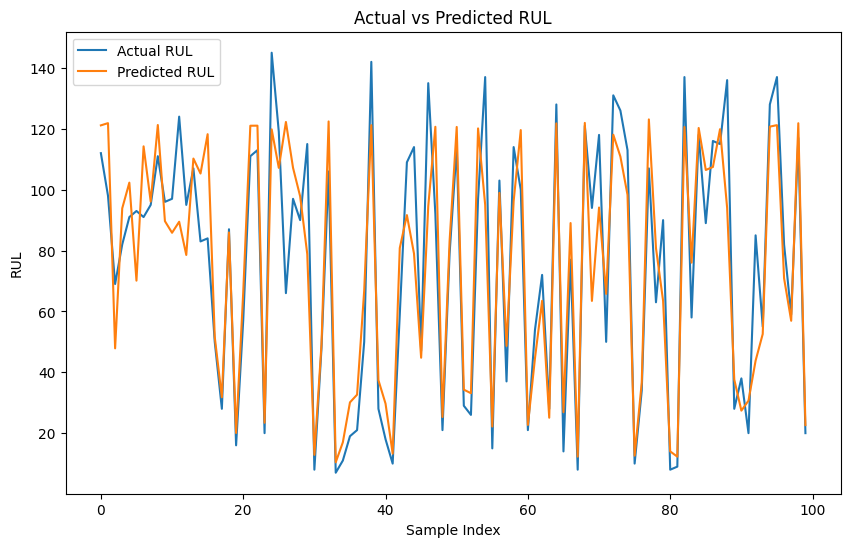

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

## Predict with Bi-LSTM

In [20]:
y_test_pred = bi_lstm_model.predict(X_test)
bi_lstm_testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
bi_lstm_testing_rmse

4/4 [==============================] - 0s 9ms/step


16.940472296285765

4/4 [==============================] - 0s 8ms/step


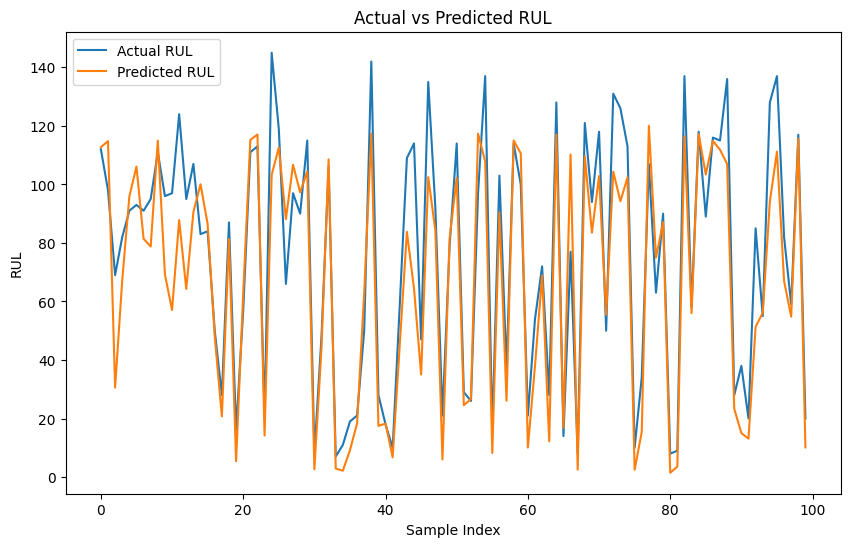

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(bi_lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

## Predict with CNN-LSTM

In [22]:
y_test_pred = cnn_lstm_model.predict(X_test)
cnn_lstm_testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
cnn_lstm_testing_rmse

4/4 [==============================] - 0s 2ms/step


13.547476318820129

4/4 [==============================] - 0s 2ms/step


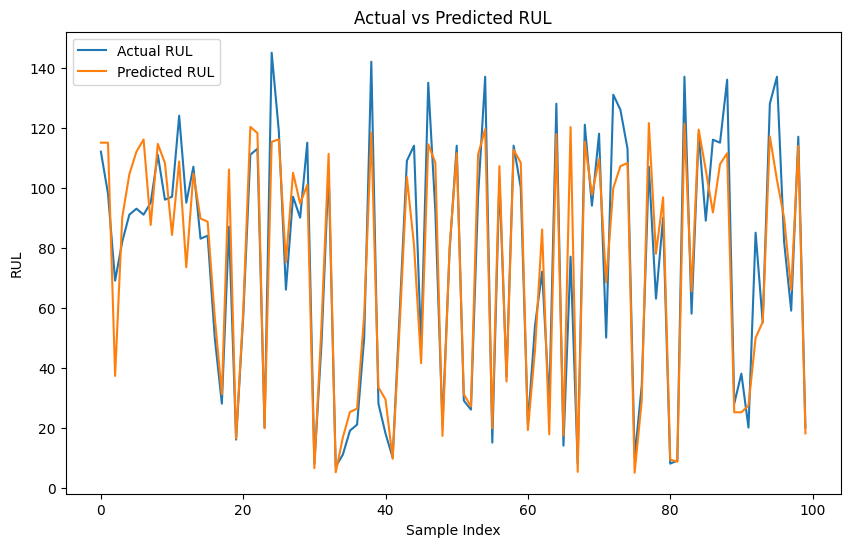

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(cnn_lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

# Comparison Between Validation and Testing

In [24]:
import pandas as pd

# Create a dictionary with the results
results = {
    'Model': ['LSTM', 'CNN-LSTM', 'Bi-LSTM'],
    'Validation RMSE': [lstm_validation_rmse, cnn_lstm_validation_rmse, bi_lstm_validation_rmse],
    'Testing RMSE': [lstm_testing_rmse, cnn_lstm_testing_rmse, bi_lstm_testing_rmse]
}

# Create the DataFrame
results_df = pd.DataFrame(results)

# Set 'Model' as the index for better presentation
results_df.set_index('Model', inplace=True)

# Display the table
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
          Validation RMSE  Testing RMSE
Model                                  
LSTM            16.300511     17.439621
CNN-LSTM        12.210591     13.547476
Bi-LSTM         13.267326     16.940472


# Saving of Scale & Models

In [35]:
# MinMaxScaler
import pickle
with open('./scale/minmax_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [36]:
# Saving LSTM Model
lstm_model.save('./models/lstm_model.h5')

In [37]:
# Saving Bi-LSTM Model
bi_lstm_model.save('./models/bi_lstm_model.h5')

In [38]:
# Saving CNN-lstm Model
cnn_lstm_model.save('./models/cnn_lstm_model.h5')

# Loading Model Instead of Retraining

In [29]:
import pickle

with open('./scale/minmax_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [30]:
from tensorflow.keras.models import load_model

lstm_model = load_model('./models/lstm_model.h5')
bi_lstm_model = load_model('./models/bi_lstm_model.h5')
cnn_lstm_model = load_model('./models/cnn_lstm_model.h5')

In [31]:
# Run Prepping of Testing Data Block on Top

# Ensemble
- Simple Average
- Weighted (?) -> giving weights to each of the model
- Stacking Ensemble

## Simple Average Ensemble

In [32]:
# Make predictions on the test set with each model
y_pred_lstm = lstm_model.predict(X_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)
y_pred_bi_lstm = bi_lstm_model.predict(X_test)

# Reshape predictions if necessary
y_pred_lstm = y_pred_lstm.flatten()
y_pred_cnn_lstm = y_pred_cnn_lstm.flatten()
y_pred_bi_lstm = y_pred_bi_lstm.flatten()

# Simple average of predictions
y_pred_ensemble = (y_pred_lstm + y_pred_cnn_lstm + y_pred_bi_lstm) / 3

# Evaluate ensemble performance
from sklearn.metrics import mean_squared_error

rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
print(f'Ensemble RMSE (Simple Average): {rmse_ensemble:.2f}')

4/4 [==============================] - 1s 15ms/step
Ensemble RMSE (Simple Average): 13.93


## Stacking Ensemble
- Must split the training data to get teh validation set
- Validation set is used to train the meta model

In [33]:
meta_features_val = np.column_stack((y_pred_lstm, y_pred_cnn_lstm, y_pred_bi_lstm))
meta_target_val = y_test

In [34]:
# The following is wrong because we should have used the base lstm, cnn-lstm, bi-lstm models to predict validation set
# Used the validation set result to fit the linear regression
from sklearn.linear_model import LinearRegression

# Initialize the meta-model
meta_model = LinearRegression()

# Train the meta-model on the validation set predictions
meta_model.fit(meta_features_val, meta_target_val)

LinearRegression()